In [1]:
from coilspy.normalization import CoilNormalizer, segment_time_series
from coilspy.neuralcoil import NeuralCoilLayer

import pandas as pd
import numpy as np

In [2]:
# Load in csv
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:1000,:]

In [3]:
# Instantiate CoilNormalizer
coilnormer = CoilNormalizer()

coilnormed_df = coilnormer.normalize(df)

                     p (mbar)  p (mbar)  T (degC)  T (degC)  Tpot (K)  \
Date Time                                                               
2009-01-01 00:20:00  0.413793  0.586207  0.634483  0.365517  0.633562   
2009-01-01 00:30:00  0.568966  0.431034  0.534483  0.465517  0.534247   
2009-01-01 00:40:00  0.534483  0.465517  0.431034  0.568966  0.428082   
2009-01-01 00:50:00  0.500000  0.500000  0.486207  0.513793  0.489726   
2009-01-01 01:00:00  0.517241  0.482759  0.424138  0.575862  0.421233   
...                       ...       ...       ...       ...       ...   
2009-01-07 22:00:00  0.310345  0.689655  0.272414  0.727586  0.277397   
2009-01-07 22:10:00  0.206897  0.793103  0.462069  0.537931  0.465753   
2009-01-07 22:20:00  0.155172  0.844828  0.703448  0.296552  0.708904   
2009-01-07 22:30:00  0.327586  0.672414  0.689655  0.310345  0.691781   
2009-01-07 22:40:00  0.293103  0.706897  0.634483  0.365517  0.636986   

                     Tpot (K)  Tdew (degC)  Tdew (

In [4]:
# We should be able to take any slice of the coilnormed timeseries and reproduce
start_index = 200
end_index = 300
df_orig_slice = df.iloc[start_index:end_index,:]
coilnormed_df_slice = coilnormed_df.iloc[start_index:end_index -1,:]
initial_value_slice = df.iloc[start_index,:]

denormed_slice = coilnormer.denormalize(coilnormed_df_slice,initial_value_slice)

In [5]:
import plotly.graph_objects as go

# Sample data creation
df1 = denormed_slice
df2 = df_orig_slice

# Plotting
fig = go.Figure()

# Add traces for the first dataframe
for column in df1.columns:
    fig.add_trace(go.Scatter(x=df2.index, y=df1[column], mode='lines', name=f'Denormed: {column}'))

# Add traces for the second dataframe
for column in df2.columns:
    fig.add_trace(go.Scatter(x=df2.index, y=df2[column], mode='lines', name=f'Orig: {column}'))

# Update layout
fig.update_layout(title='Interactive Time Series Plot',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  legend_title='Legend',
                  hovermode='x unified')

# Show the plot
fig.show()


In [6]:
# Neural Coil Testing
import torch

# Generate and segment the time series
series = coilnormed_df.values
length = 36

series_x = series[:-1,]
series_y = series[1:,]

segments_x = segment_time_series(series_x, length)
segments_y = segment_time_series(series_y, length)

# Convert to tensors
segments_tensor_x = torch.tensor(segments_x, dtype=torch.float)
segments_tensor_y = torch.tensor(segments_y, dtype=torch.float)

# Prepare inputs and targets
X = segments_tensor_x.to("cuda")
# Shift segments to the right by one timestep to create the targets
Y =  segments_tensor_y.to("cuda")

# Get number of features and batch size
n_features = X.shape[2]
batch_size = X.shape[0]

In [7]:
from torch import nn, optim

class CoilBlock(nn.Module):
    def __init__(self, n_features, n_batch, device):
        super(CoilBlock, self).__init__()

        self.coil1 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
        self.coil2 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
        self.coil3 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
    
    def forward(self, x):
        x, transition_tensor = self.coil1(x)
        x, transition_tensor = self.coil2(x)
        #x, transition_tensor = self.coil3(x)
        return x, transition_tensor
    
# Model

# Single Coil
model = NeuralCoilLayer(
    n_features = n_features,
    n_batch = X.shape[0],
    device="cuda"
).to("cuda")

# Coil Block
# model = CoilBlock(n_features=n_features, n_batch= X.shape[0], device="cuda").to("cuda")

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs, transition_tensor = model(X)
    loss = criterion(outputs, Y)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

Epoch [10/300], Loss: 3.628007470979355e-05
Epoch [20/300], Loss: 3.447515337029472e-05
Epoch [30/300], Loss: 3.320825635455549e-05
Epoch [40/300], Loss: 3.2215768442256376e-05
Epoch [50/300], Loss: 3.149794429191388e-05
Epoch [60/300], Loss: 3.129317701677792e-05
Epoch [70/300], Loss: 3.0441980925388634e-05
Epoch [80/300], Loss: 2.9910395824117586e-05
Epoch [90/300], Loss: 3.064561678911559e-05
Epoch [100/300], Loss: 2.9486896892194636e-05
Epoch [110/300], Loss: 2.8898839445901103e-05
Epoch [120/300], Loss: 3.0264634915511124e-05
Epoch [130/300], Loss: 2.9468281354638748e-05
Epoch [140/300], Loss: 2.8211852622916922e-05
Epoch [150/300], Loss: 2.7462883736006916e-05
Epoch [160/300], Loss: 2.8693162676063366e-05
Epoch [170/300], Loss: 2.7828213205793872e-05
Epoch [180/300], Loss: 2.6966274162987247e-05
Epoch [190/300], Loss: 2.6392421204946004e-05
Epoch [200/300], Loss: 2.6053879992105067e-05
Epoch [210/300], Loss: 2.5765044483705424e-05
Epoch [220/300], Loss: 2.551539000705816e-05
Epoc

In [10]:
import plotly.graph_objects as go

def plot_model_output_vs_target(model_outputs, targets, batch_index=0, feature_index=0):
    # Extract the specified feature for the given batch from both the model outputs and targets
    model_output_series = model_outputs[batch_index, :, feature_index].detach().numpy()
    target_series = targets[batch_index, :, feature_index].numpy()
    
    # Create a range for the x-axis (timesteps)
    timesteps = list(range(model_output_series.shape[0]))
    
    # Create traces
    model_trace = go.Scatter(x=timesteps, y=model_output_series, mode='lines', name='Model Output')
    target_trace = go.Scatter(x=timesteps, y=target_series, mode='lines', name='Target')
    
    # Create the figure and add traces
    fig = go.Figure()
    fig.add_trace(model_trace)
    fig.add_trace(target_trace)
    
    # Add title and labels
    fig.update_layout(title=f'Model Output vs Target for Feature {feature_index}, Batch {batch_index}',
                      xaxis_title='Timestep',
                      yaxis_title='Value')
    
    # Show the figure
    fig.show()

# Assuming `y` and `Y` are your model outputs and targets, respectively
# Adjust batch_index and feature_index as needed
plot_model_output_vs_target(outputs.to("cpu"), Y.to("cpu"), batch_index=1, feature_index=0)

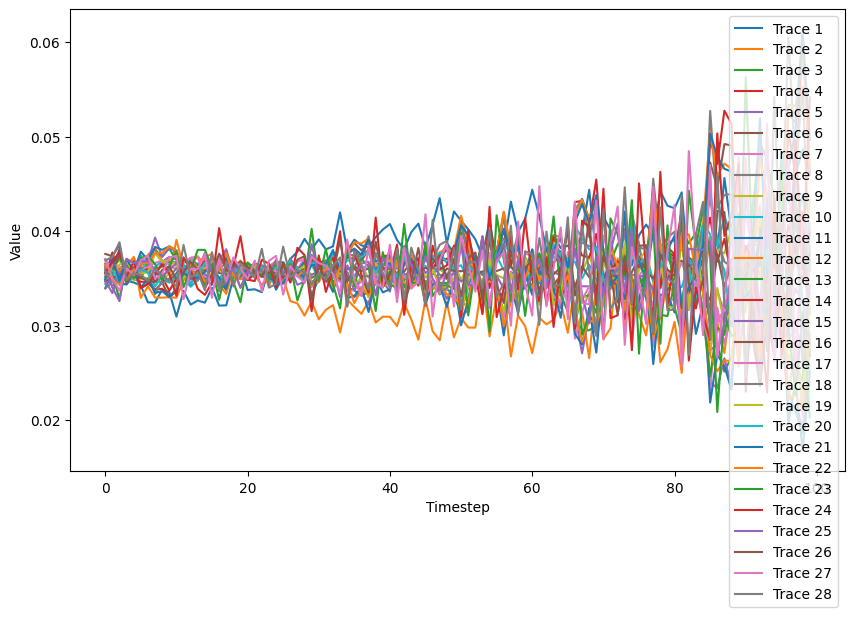

In [11]:
import matplotlib.pyplot as plt

states = []
batch = 0
state_tensor = X[:,0,:]
batch_size = X.shape[0]
transition_tensor = torch.zeros(batch_size, n_features, n_features).to("cuda")
for step_state in range(100):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor[batch,:])
    #print(sum(state_tensor[batch,:]))
    

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()